In [2]:
# import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'lightgray'


import warnings
warnings.filterwarnings('ignore')

In [7]:
# loading datasets

df_train_users = pd.read_csv("airbnb-recruiting-new-user-bookings/train_users_2.csv") # training dataset
df_test_users = pd.read_csv("airbnb-recruiting-new-user-bookings/test_users.csv") # testing dataset
df_countries = pd.read_csv("airbnb-recruiting-new-user-bookings/countries.csv")
df_age_gender = pd.read_csv('airbnb-recruiting-new-user-bookings/age_gender_bkts.csv')
df_sessions = pd.read_csv('airbnb-recruiting-new-user-bookings/sessions.csv')

# df_train_users.shape, df_test_users.shape, df_countries.shape, df_age_gender.shape, df_sessions.shape
print(f'Training set contains {df_train_users.shape[0]} users, ' 
      + f'and the testing dataset contains {df_test_users.shape[0]}, '
      + f'giving a grand total of {df_train_users.shape[0] + df_test_users.shape[0]} users.')

Training set contains 213451 users, and the testing dataset contains 62096, giving a grand total of 275547 users.


In [8]:
# combining train and test datasets
all_users = pd.concat((df_train_users, df_test_users), axis=0, ignore_index=True)

all_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [9]:
[print(f"{col} has {all_users[col].isnull().sum()} null values.", end='\n\n') for col in all_users.columns if all_users[col].isnull().sum() != 0]

date_first_booking has 186639 null values.

age has 116866 null values.

first_affiliate_tracked has 6085 null values.

country_destination has 62096 null values.



[None, None, None, None]

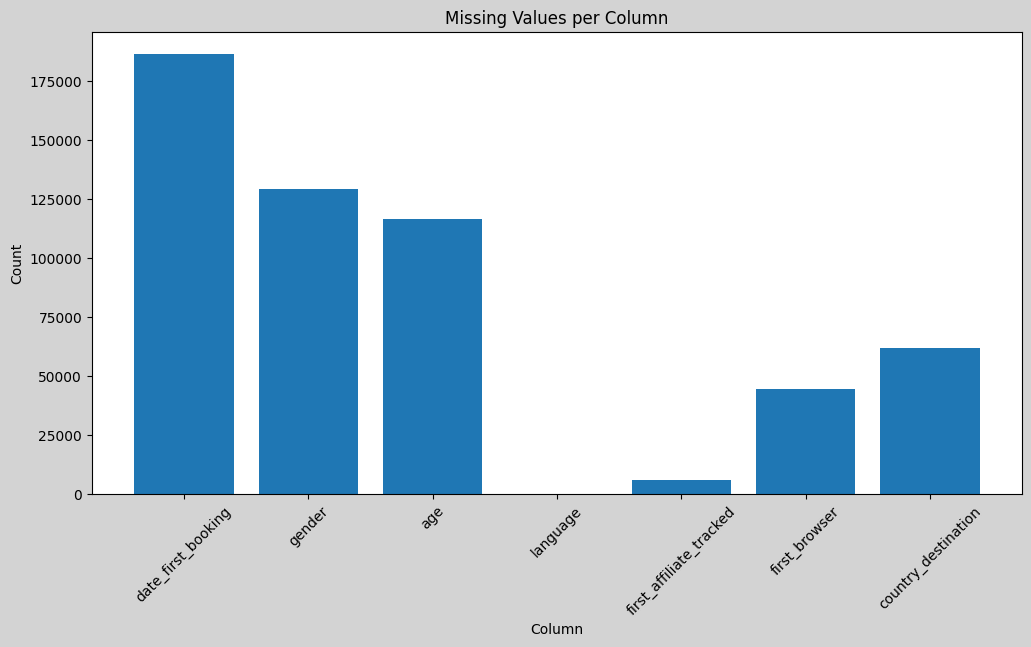

In [10]:
all_columns = all_users.columns.tolist()

missing_counts = []
for col in all_columns:
    count = all_users[col].isnull().sum() + all_users[col].eq('-unknown-').sum()
    if count > 0:
        missing_counts.append((col, count))

if missing_counts:
    missing_counts = pd.DataFrame(missing_counts, columns=['column', 'count'])

    plt.figure(figsize=(12, 6))
    plt.bar(missing_counts['column'], missing_counts['count'])
    plt.xticks(rotation=45)
    plt.xlabel('Column')
    plt.ylabel('Count')
    plt.title('Missing Values per Column')
    plt.show()
else:
    print("No columns with missing values found.")

Each of these columns and their missing or incompatible data needs to be addressed. Lets start with Gender!

In [11]:
all_users.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

FEMALE    77524
MALE      68209
OTHER       334
Name: gender, dtype: int64


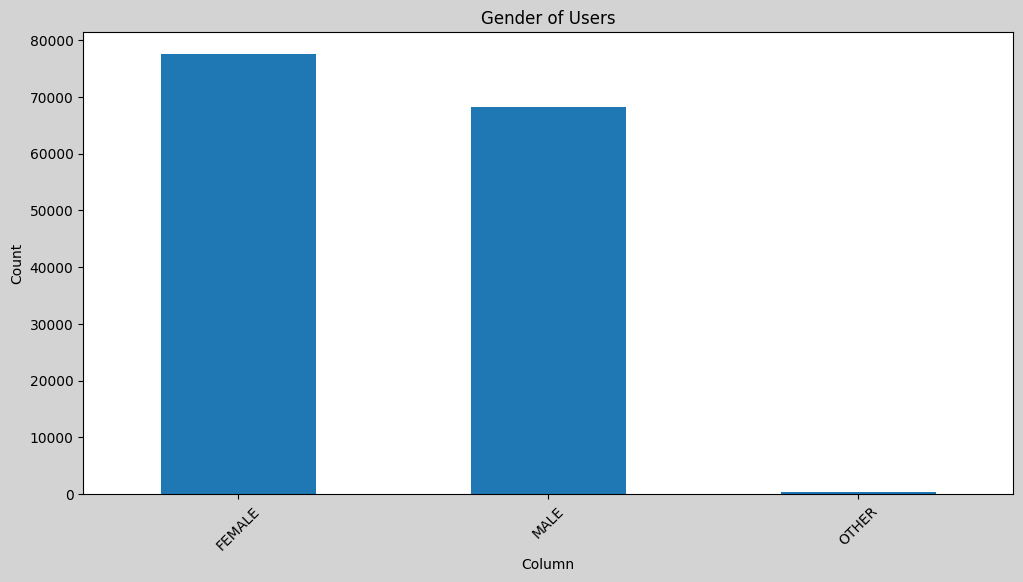

In [12]:
all_users.gender.replace('-unknown-', np.nan, inplace=True)
print(all_users.gender.value_counts())

plt.figure(figsize=(12, 6))
all_users.gender.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Column')
plt.ylabel('Count')
plt.title('Gender of Users')
plt.show()

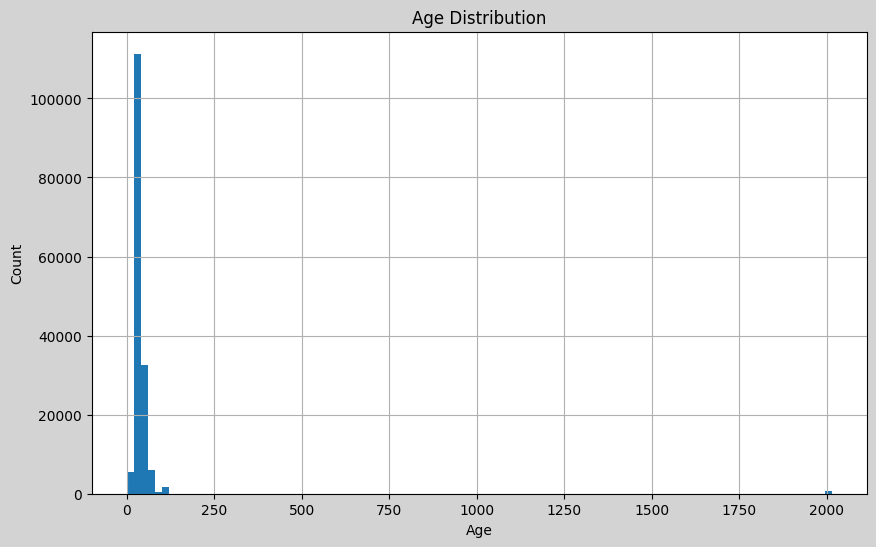

In [13]:
plt.figure(figsize=(10,6))
all_users.age.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

We need to take care of the outrageously large ages, and with a bit of creative thinking along with the help of this notebook --> https://www.kaggle.com/code/kevinwu06/airbnb-exploratory-analysis/notebook, I will assume that the very large ages should represent birth years instead. This gives us more data to work with.

Using 2010 as the reference year, as noted in the Airbnb Dataset Description, I changed the values of our users to be in a valid range of 16 to 100. Large values were converted from "birth years" to an appropriate age, and values below 16 and above 100 were changed to NaN.

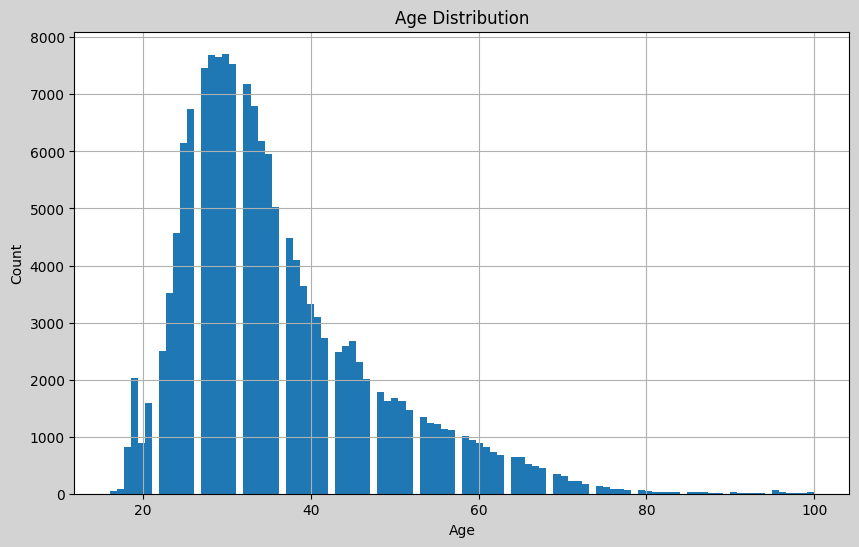

count    155993.000000
mean         36.073824
std          11.691587
min          16.000000
25%          28.000000
50%          33.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64


In [14]:
ages = all_users['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
all_users['age'] = ages

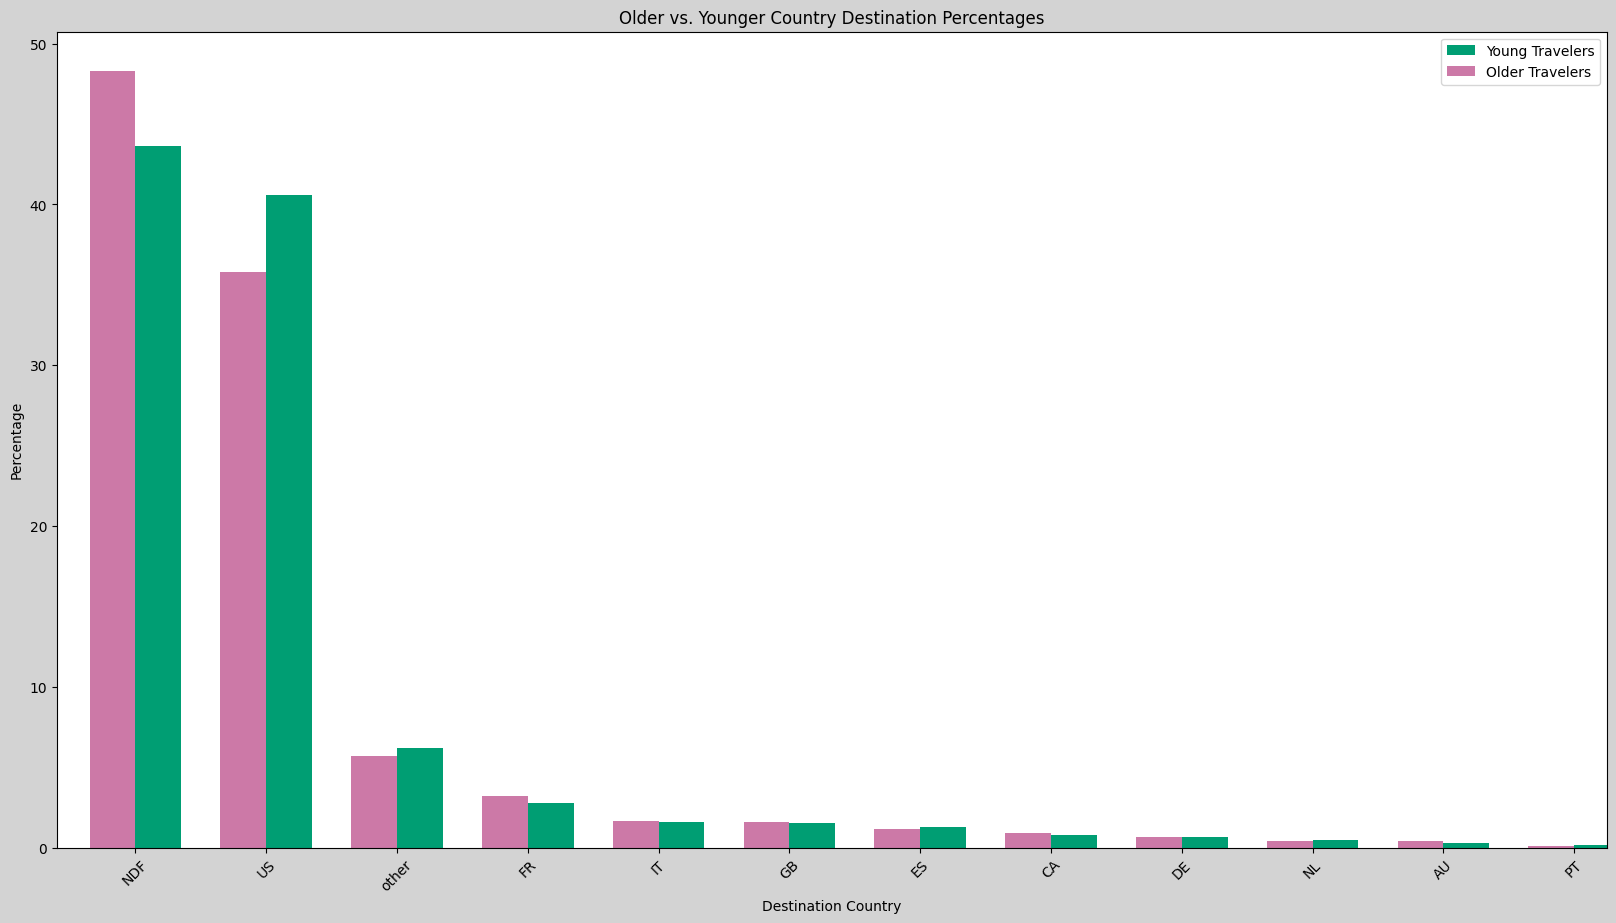

In [15]:
middle_age = 36

plt.figure(figsize=(20,12))
bar_width = 0.35

young_travelers = sum(all_users.loc[all_users['age'] < middle_age, 'country_destination'].value_counts())
old_travelers = sum(all_users.loc[all_users['age'] > middle_age, 'country_destination'].value_counts())

young_dest = all_users.loc[all_users['age'] < middle_age, 'country_destination'].value_counts() / young_travelers * 100
old_dest = all_users.loc[all_users['age'] > middle_age, 'country_destination'].value_counts() / old_travelers * 100

young_dest.plot(kind='bar', width=bar_width, position=0, label='Young Travelers', color='#009E73')
old_dest.plot(kind='bar', width=bar_width, position=1, label='Older Travelers', color='#CC79A7')


plt.legend()
plt.title('Older vs. Younger Country Destination Percentages')
plt.xlabel('Destination Country')
x_ticks = range(len(young_dest.index))
plt.xticks(rotation=45)
plt.ylabel('Percentage')
plt.subplots_adjust(bottom=0.2)
plt.show()

In [21]:
# travel_data = all_users[['country_destination', 'gender']]
# travel_data['age_group'] = ['young' if age < middle_age else 'old' for age in all_users['age']]

# # Calculate the percentage of travelers for each age group and gender
# young_travelers = travel_data.loc[travel_data['age_group'] == 'young', ['country_destination', 'gender']].value_counts()
# young_travelers = young_travelers.groupby([young_travelers.index.get_level_values(0), young_travelers.index.get_level_values(1)]).transform('count').unstack('gender')
# young_travelers = young_travelers.div(young_travelers.sum(axis=1), axis=0) * 100

# old_travelers = travel_data.loc[travel_data['age_group'] == 'old', ['country_destination', 'gender']].value_counts()
# old_travelers = old_travelers.groupby([old_travelers.index.get_level_values(0), old_travelers.index.get_level_values(1)]).transform('count').unstack('gender')
# old_travelers = old_travelers.div(old_travelers.sum(axis=1), axis=0) * 100

# # Create the stacked bar chart
# plt.figure(figsize=(20, 12))
# bar_width = 0.35

# young_dest = young_travelers.plot(kind='bar', width=bar_width, position=0, label='Young Travelers', color=['#009E73', '#00B4D8'], stacked=True)
# old_dest = old_travelers.plot(kind='bar', width=bar_width, position=1, label='Older Travelers', color=['#CC79A7', '#F0E442'], stacked=True)

# plt.legend(labels=['Young Males', 'Young Females', 'Older Males', 'Older Females'])
# plt.title('Older vs. Younger Country Destination Percentages by Gender')
# plt.xlabel('Destination Country')
# x_ticks = range(len(young_travelers.index))
# plt.xticks(x_ticks, young_travelers.index.get_level_values(0), rotation=45)
# plt.ylabel('Percentage')
# plt.subplots_adjust(bottom=0.2)
# plt.show()

In [29]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA


# print(f"Number of Features: {all_users.shape[1]}")
# print("\nData Types:")
# print(all_users.dtypes)

# print("\nMissing Values:")
# print(all_users.isnull().sum())

# features = all_users.columns
# all_users[features] = StandardScaler().fit_transform(all_users[features])

# pca = PCA(n_components=2)
# df_pca = pca.fit_transform(all_users[features])

# kmeans = KMeans(n_clusters=3)
# model = kmeans.fit(df_pca)

# plt.scatter(df_pca[:, 0], df_pca[:, 1], c=model.labels_)
# plt.show()

In [28]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = all_users.select_dtypes(include=['int64', 'float64']).columns
categorical_features = all_users.select_dtypes(include=['object']).drop(['id'], axis=1).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('cluster', KMeans(n_clusters=3))])

model = clf.fit(all_users.drop('id', axis=1))


labels = model.named_steps['cluster'].labels_


In [ ]:
df_countries.head(10)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


When discussing the Levenshtein distance between languages, it is often used to measure the linguistic distance or similarity between two languages. This can be useful in various fields, such as historical linguistics, language learning, and natural language processing.  

In the context of comparing English and Spanish, the Levenshtein language distance would refer to the minimum number of character-level edits (insertions, deletions, or substitutions) required to transform words or texts from one language to the other.  

Here's an example of how you could describe the Levenshtein language distance between English and Spanish:  

The Levenshtein language distance is a metric that can be used to quantify the linguistic similarity between two languages, in this case, English and Spanish. It measures the minimum number of single-character edits needed to transform words or texts from one language into the other.  

For example, consider the English word "cat" and its Spanish equivalent "gato". The Levenshtein distance between these two words is 3, as we need to perform the following edits:  

1. Substitute 'c' with 'g'  
2. Insert 'a' after 'g'  
3. Substitute 't' with 'o'  

Therefore, the Levenshtein language distance between "cat" and "gato" is 3.  

This metric can be applied to larger texts or even entire language corpora by calculating the average Levenshtein distance between corresponding words or phrases in the two languages. A higher Levenshtein language distance indicates greater linguistic dissimilarity, while a lower distance suggests that the languages are more closely related.  

The Levenshtein language distance can be a useful tool for tasks such as language classification, language learning difficulty estimation, and identifying cognates (words with a common etymological origin) between languages. It provides a quantitative measure of the linguistic differences between two languages, which can complement other linguistic analysis techniques. 